<a href="https://colab.research.google.com/github/pyagoubi/kaggle-Feedback-Prize/blob/main/Feedback_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/MyDrive/kaggle Feedback")

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

# Import Data

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
df_train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   text_id      3911 non-null   object 
 1   full_text    3911 non-null   object 
 2   cohesion     3911 non-null   float64
 3   syntax       3911 non-null   float64
 4   vocabulary   3911 non-null   float64
 5   phraseology  3911 non-null   float64
 6   grammar      3911 non-null   float64
 7   conventions  3911 non-null   float64
dtypes: float64(6), object(2)
memory usage: 244.6+ KB


There are 3911 rows, each with an ID, a text and scores with regard to six targets.


In [7]:
df_train['full_text'].iloc[1]

"When a problem is a change you have to let it do the best on you no matter what is happening it can change your mind. sometimes you need to wake up and look what is around you because problems are the best way to change what you want to change along time ago. A\n\nproblem is a change for you because it can make you see different and help you to understand how tings wok.\n\nFirst of all it can make you see different then the others. For example i remember that when i came to the United States i think that nothing was going to change me because i think that nothing was going to change me because everything was different that my country and then i realist that wrong because a problem may change you but sometimes can not change the way it is, but i remember that i was really shy but i think that change a lot because sometimes my problems make me think that there is more thing that i never see in my life but i just need to see it from a different way and dont let nothing happened and ruing

There are several \n included, we should keep that in mind and delete them before training/ prediction.

# Check Target distributions

Skew cohesion: 0.04
Skew syntax: 0.13
Skew vocabulary: 0.22
Skew phraseology: 0.07
Skew grammar: 0.2
Skew conventions: 0.08


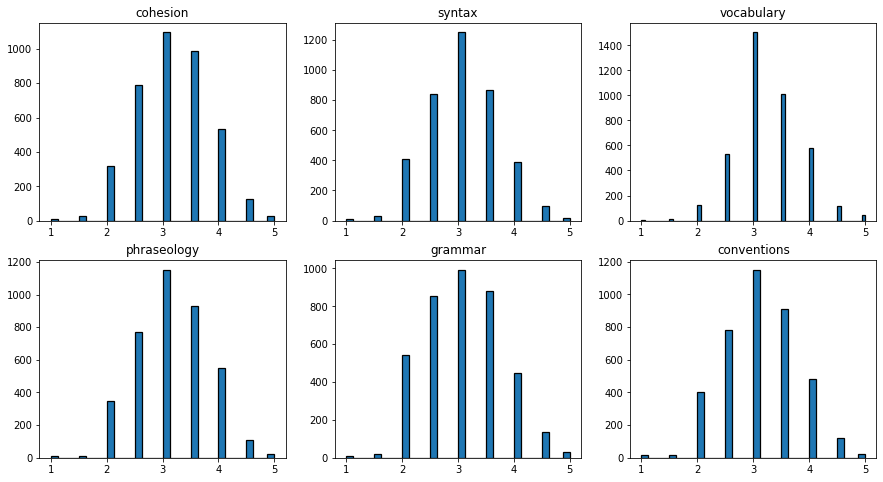

In [23]:
targets = ['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

fig, axes = plt.subplots(2, 3, figsize=(15,8))

for i, target in enumerate(targets):
    ax= axes.flat[i]
    sns.histplot(x=target, data=df_train, linewidth=1.25, alpha=1, ax=ax, zorder=2)
    ax.set_title(target)
    ax.set(xlabel=None, ylabel=None)
    print(f'Skew {target}:', round(df_train[target].skew(), 2))
    
plt.show()

Scores seem normally distributed around 3 with slight positive skew.

# Correlations

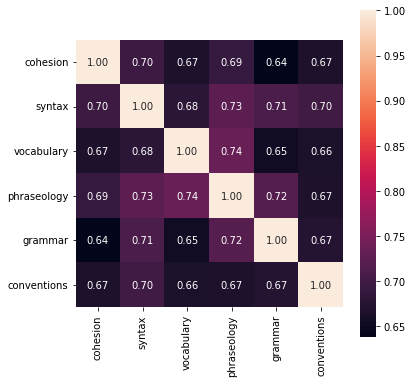

In [24]:
corr = df_train[targets].corr()
fig, ax = plt.subplots(figsize=(6,6))        
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, square=True, annot=True, fmt=".2f")
plt.show()

In [27]:
corr.mean()

cohesion       0.726085
syntax         0.751840
vocabulary     0.733520
phraseology    0.756229
grammar        0.732686
conventions    0.728435
dtype: float64

Targets seem to be strong correlated.

In [28]:
df_train['total'] = df_train[targets].sum(axis=1)

In [38]:
print('Total score: \n'
'Min: ', df_train['total'].min(), '\n'
'Max: ', df_train['total'].max(), '\n'
'Mean: ', df_train['total'].mean(), '\n'
'Median: ', df_train['total'].median())

Total score: 
Min:  6.0 
Max:  30.0 
Mean:  18.621835847609308 
Median:  18.5


# Correlation with No. of words

In [64]:
df_train['num_words'] = df_train['full_text'].apply(lambda x: len(x.split()))
lw = targets + ['num_words']
corr_lw = df_train[lw].corr()
corr_lw['num_words'].sort_values(ascending = False)

num_words      1.000000
vocabulary     0.271143
cohesion       0.218739
phraseology    0.214308
syntax         0.188038
conventions    0.143493
grammar        0.080283
Name: num_words, dtype: float64

In [66]:
corr_lw_upper = df_train.loc[df_train['num_words']<200, lw].corr()
corr_lw_upper['num_words'].sort_values(ascending = False)

num_words      1.000000
cohesion       0.264283
phraseology    0.239876
syntax         0.191590
grammar        0.138488
vocabulary     0.113584
conventions    0.110316
Name: num_words, dtype: float64

In [67]:
corr_lw_upper = df_train.loc[df_train['num_words']>600, lw].corr()
corr_lw_upper['num_words'].sort_values(ascending = False)

num_words      1.000000
vocabulary    -0.029917
phraseology   -0.052860
syntax        -0.063823
cohesion      -0.067688
conventions   -0.092318
grammar       -0.098629
Name: num_words, dtype: float64

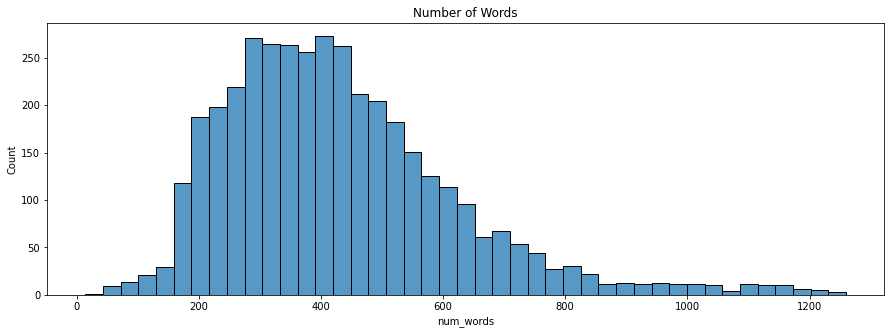

In [42]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df_train, x="num_words")
plt.title("Number of Words")
plt.show()

# Word Cloud

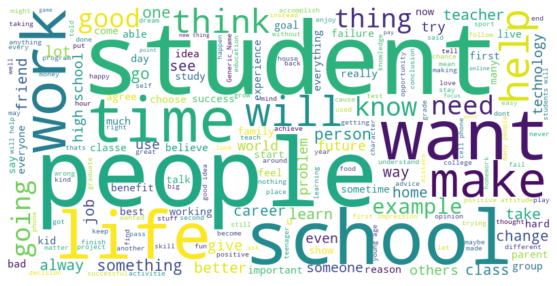

In [68]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df_train.full_text))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()